<a href="https://colab.research.google.com/github/devdogukan/turkish-news-classification/blob/main/turkish-news-categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turkish News Categorization

## Introduction

### News Classification
In this project, we will develop a machine learning-based model to classify news articles into different categories. News classification is an essential task in natural language processing (NLP) that involves assigning a given news article to a specific category based on its content.

We will use a dataset containing news articles from various topics, where each article is labeled with a predefined category. Our goal is to build a model that can accurately predict the category of a given news article.

The categories we will focus on in this project are:

Politics

Economy

Sports

Technology

Health

World News

Culture

By leveraging machine learning and NLP techniques, we aim to develop an efficient and accurate news classification model.

Let's get started! 🚀

## Explore Data

In [1]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/NLP/News/turkish-news.csv")

In [2]:
df.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [4]:
df.describe()

,category,text
count,4900,4900
unique,7,4539
top,siyaset,messi nin emzik sürpriz bozuldu ! barcelona n...
freq,700,5


In [5]:
df['category'].value_counts()

,count
category,
siyaset,700
dunya,700
ekonomi,700
kultur,700
saglik,700
spor,700
teknoloji,700


## Text preprocessing

### Clean & Normalization

In [6]:
import re
import string

def normalize_text(text):
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
df['normalized_text'] = df['text'].apply(normalize_text)

### Tokenization and Padding

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

# Max word count
MAX_WORDS = 10000
# Max news length
MAX_LENGTH = 200

# Creating a tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['normalized_text'])

# Convert text to numeric arrays
sequences = tokenizer.texts_to_sequences(df['normalized_text'])

# Bringing to the same length
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [9]:
!pip install TurkishStemmer

### Lemmatization

In [10]:
from TurkishStemmer import TurkishStemmer

stemmer = TurkishStemmer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [stemmer.stem(word) for word in words]
    return ' '.join(lemmatized_words)

df['lemmatized_text'] = df['normalized_text'].apply(lemmatize_text)

# You can repeat the tokenization process on lemmatized texts
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['lemmatized_text'])
sequences = tokenizer.texts_to_sequences(df['lemmatized_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

## Model Building and Training

In [50]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional # type: ignore
import numpy as np

# Convert categories to numbers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['category'])
categorical_labels = to_categorical(encoded_labels)

# Split train and test datas
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    categorical_labels,
    test_size=0.2,
    random_state=42,
    stratify=categorical_labels
)

# Creating a model
model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(df['category'].unique()), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2204 - loss: 1.8579 - val_accuracy: 0.4719 - val_loss: 1.3584
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5879 - loss: 1.1167 - val_accuracy: 0.7398 - val_loss: 0.7748
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8435 - loss: 0.4839 - val_accuracy: 0.8061 - val_loss: 0.6348
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9419 - loss: 0.2611 - val_accuracy: 0.8265 - val_loss: 0.6298
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9711 - loss: 0.1470 - val_accuracy: 0.8036 - val_loss: 0.7253
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9830 - loss: 0.0933 - val_accuracy: 0.8087 - val_loss: 0.8371
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9905 - loss: 0.0553 - val_accuracy: 0.8112 - val_loss: 0.9766
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9860 - loss: 0.0634 - val_accuracy: 0.824

In [51]:
# Summary of the model
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,273,943 (16.30 MB)

 Trainable params: 1,424,647 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,849,296 (10.87 MB)

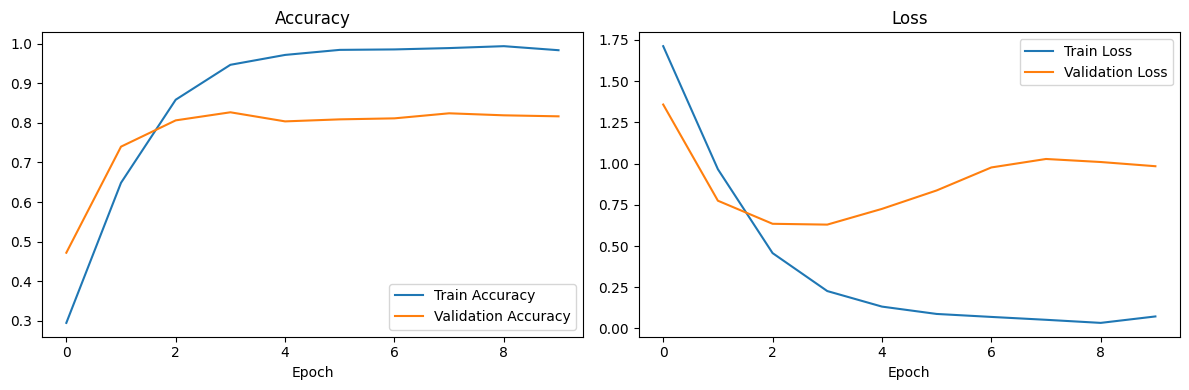

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Visualizing
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

## Model Evaluation

In [53]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8568 - loss: 0.7466
Test Accuracy: 0.8520


In [54]:
category_names = label_encoder.classes_

print(classification_report(y_true, y_pred, target_names=category_names))

              precision    recall  f1-score   support

      dunya        0.83      0.81      0.82       140
    ekonomi        0.79      0.83      0.81       140
     kultur        0.75      0.89      0.81       140
     saglik        0.94      0.85      0.89       140
    siyaset        0.88      0.81      0.84       140
       spor        0.92      0.97      0.94       140
  teknoloji        0.88      0.80      0.84       140

    accuracy                           0.85       980
   macro avg       0.86      0.85      0.85       980
weighted avg       0.86      0.85      0.85       980



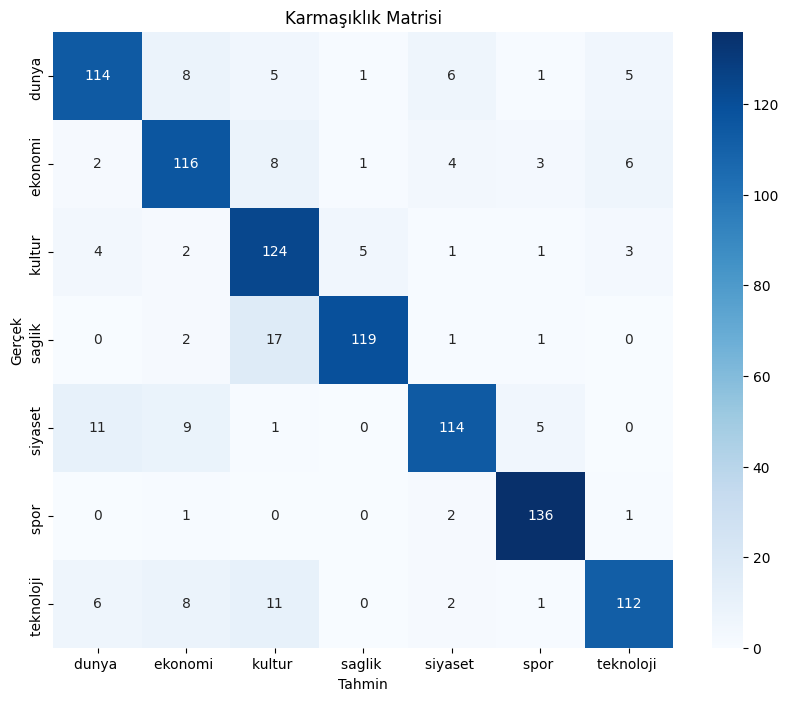

In [55]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karmaşıklık Matrisi')
plt.show()

In [56]:
# Save model architecture as JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/NLP/News/turkish-news-categorization-model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weihts
model.save_weights("/content/drive/MyDrive/NLP/News/turkish-news-categorization-weights.weights.h5")

# Save the full model
model.save("/content/drive/MyDrive/NLP/News/turkish-news-categorization.keras")

# Save the tokenizer
import pickle
with open('/content/drive/MyDrive/NLP/News/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the LabelEncoder
with open('/content/drive/MyDrive/NLP/News/label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)